# Q_Learning - Fire Spread pattern

In [2]:
"""
FileName: Q_learning_fire_spread_pattern_v{version_no}
Author: Priyanka Singhal
Python Version: 3.7.3
Date Created: April 12, 2020
"""

'\nFileName: Q_learning_fire_spread_pattern_v{version_no}\nAuthor: Priyanka Singhal\nPython Version: 3.7.3\nDate Created: April 12, 2020\n'

# STEP[1]: Import Libraries

In [24]:
import os 
import time 
from random import shuffle 
from random import random 
from copy import deepcopy
import numpy as np 
import collections
import pandas as pd

# STEP[2]: Declare Constants - States, Action, Rewards and Model Parameters

In [25]:
# Define constants
ALGORITHM_NAME = "Q_Learning"
#WORKDIR = '/Users/priyankasinghal/Documents/RL_algo/'
WORKDIR = os.getcwd()
IMAGE_FILEPATH=WORKDIR + "/Dataset/ndvi/"
FILENAME = WORKDIR + "/MergedData.csv"

# Define STATES S - [x, y, v, f, ws, wd, t]
    # States -
    # Actions - 9 - [N, S, E, W, NW, SW, NE, NW Stay]
    # NSTATES - 
    
#     x, y (block row and column)
#     Veg_type
#     0. Grasslands, Vernal Pools, Meadows, and Other Herb Communities
#     1. Scrub and Chaparral
#     2. Disturbed or Developed Areas
#     3. Water
#     4. Woodland
#     5. Forest
#     6. Dune Community
#     7. Riparian and Bottomland Habitat

#     Fire_nofire
#     0 - no fire
#     1 - fire

#     Wind_Speed
#     0 - 0 - 12 mph
#     1 - 12 - 24 mph
#     2 - 24 - 38mph

#     Wind_Direction
#     0 - N
#     1 - S
#     2 - E
#     3 - W
#     4 - NE
#     5 - NW
#     6 - SE
#     7 - SW

#     Temperature
#     0 - <= 32F
#     1 - 32.1 - 70F
#     2  - 70.1F - 90F
#     3 - > 90F

# Define State Ranges
MAX_VEG_TYPE = 8
MAX_FIRE = 2
MAX_WS = 3
MAX_WD = 8
MAX_TEMP = 4

states_range = {}

states_range['veg_type_range'] = range(0, MAX_VEG_TYPE)
states_range['fire_range'] = range(0, MAX_FIRE)
states_range['ws_range'] = range(0, MAX_WS)
states_range['wd_range'] = range(0, MAX_WD)
states_range['temp_range'] = range(0, MAX_TEMP)
 
# All actions A Fire can take: A - [N, S, E, W, NW, SW, NE, SE Stay]
actions = [(-1,0),
           (1,0), 
           (0,1),  
           (0,-1),
           (-1,-1), #NW
          (1,-1), #SW
          (-1,1), #NE
          (1,1), #SE
          (0,0)]

# Model Parameters
# Probability fire will try to take action a 
                            # according to policy pi(s) = a and fail.
PROB_FAILURE = 0.20
PROB_SUCCESS = 1 - PROB_FAILURE
GAMMA = 0.9  # gamma, also known as discount rate. Determines by how much
                # we discount the value of a future state s'
LEARNING_RATE = 0.25
ERROR_THRES = 0.001 # Determine when Q-values stabilize (i.e.theta)

NO_TRAINING_ITERATIONS = 10 # A single training iteration runs through all
                            # possible states s
MAX_STEPS = 500
NO_OF_TRIALS = 10
FRAME_TIME = 0.3 # How many seconds between frames printed to the console
MAX_TRAIN_ITER = 10000000 # Maximum number of training 
TRAIN_ITER_LENGTH = 10
reward = 0
dataset_col_list = ['row', 'col','latitude', 'longitude',
                    'fire_nofire', 'category','wind_speed','wind_direction',
                    'temperature', 'filename']

START = [0, 0]
MAX_ROWS = 16
MAX_COLS = 16
GOAL = (0, 3)
#Declaring named tuple for environment data
environment = []
IMAGES=[]
CLASSES=[]

In [29]:
pd.read_csv('./MergedData.csv')

Station;Date;Latitude;Longitude;AirTemp;WindDirection;WindSpeed;Elevation;ndvi;nbr;nbr2;msavi;ndmi
0       4600237;2020-01-01T00:00:00;37.8;-122.6;;;;250...                                                
1       AAMC1;2020-01-01T00:00:00;37.77;-122.3;56.5;;;...                                                
2       DPXC1;2020-01-01T00:00:00;38.06;-122.26;57.7;8...                                                
3       FTPC1;2020-01-01T00:00:00;37.81;-122.47;57.0;2...                                                
4       LNDC1;2020-01-01T00:00:00;37.8;-122.28;59.5;21...                                                
...                                                   ...                                                
118829  PXSC1;2020-01-31T23:54:00;37.8;-122.4;65.3;;;2...                                                
118830  RCMC1;2020-01-31T23:54:00;37.92;-122.41;63.3;3...                                                
118831  RTYC1;2020-01-31T23:54:00;37.51;-122.21;64.6;3...                                                
118832  UPBC1;2020-01-31T23:54:00;38.04;-122.12;;90.0;...                                                
118833  TIBC1;2020-01-31T23:59:00;37.89;-122.45;61.2;3...                                                

[118834 rows x 1 columns]

# Fire Spread Problem Formulation using Markov Decision Process

# STEP[3]: Read Environment

In [18]:
import pandas
from PIL import Image

# helper functions for states
def encode_veg_type(x):
        x = x.lower()
        if x == 'grasslands, vernal pools, meadows, and other herb communities':
            return 0
        elif x == 'scrub and chaparral':
            return 1
        elif x == 'disturbed or developed areas':
            return 2
        elif x == 'water':
            return 3
        elif x == 'woodland':
            return 4
        elif x == 'forest':
            return 5
        elif x == 'dune community':
            return 6
        elif x == 'riparian and bottomland habitat':
            return 7
        
def encode_ws(x):
        if x >= 0 and x <= 12:
            return 0
        elif x > 12 and x <= 24:
            return 1
        else:
            return 2

#[N, S, E, W, NW, SW, NE, SE Stay]        
def encode_wd(x):
        if x == 'N':
            return 0
        elif x == 'S':
            return 1
        elif x == 'E':
            return 2
        elif x == 'W':
            return 3
        elif x == 'NW':
            return 4
        elif x == 'SW':
            return 5
        elif x == 'NE':
            return 6
        else:
            #SE
            return 7
        
def encode_temp(x):
        if x >= 0 and x <= 32:
            #low
            return 0
        elif x > 32 and x <= 70:
            #average
            return 1
        elif x > 70 and x <= 90:
            #high
            return 2
        else:
            #dangerously high
            return 3
        
def get_encode_env_labels(pandas_df):
    """
    This method converts encodes raw environment (i.e. cell) labels
    :param pandas_df environment data
    :return updated environment
    :rtype list
    """
    
    #     Veg_type
    #     0. Grasslands, Vernal Pools, Meadows, and Other Herb Communities
    #     1. Scrub and Chaparral
    #     2. Disturbed or Developed Areas
    #     3. Bog and Marsh
    #     4. Woodland
    #     5. Forest
    #     6. Dune Community
    #     7. Riparian and Bottomland Habitat
    pandas_df['category'] = pandas_df['category'].apply(encode_veg_type)
    
    #     Fire_nofire
    #     0 - no fire
    #     1 - fire
    pandas_df['fire_nofire'] = pandas_df['fire_nofire'].apply(lambda x: 0 if x.lower() == 'no fire' else 1)
    
    #     Wind_Speed
    #     0 - 0 - 12 mph
    #     1 - 12 - 24 mph
    #     2 - 24 - 38 mph
    pandas_df['wind_speed'] = pandas_df['wind_speed'].apply(encode_ws)
    
    #     Wind_Direction
    #     0 - N
    #     1 - S
    #     2 - E
    #     3 - W
    pandas_df['wind_direction'] = pandas_df['wind_direction'].apply(encode_wd)

    #     Temperature
    #     0 - <= 32F
    #     1 - 32.1 - 70F
    #     2  - 70.1F - 90F
    #     3 - > 90F
    pandas_df['temperature'] = pandas_df['temperature'].apply(encode_temp)
    
    return pandas_df
 
def read_environment(filename):
    """
    This method reads in the environment (i.e. cell)
    :param str filename
    :return environment: list of namedtuples - each tuple represents a cell state
    :rtype list
    """
    df = pandas.read_csv(filename, header=0, nrows=256, names=dataset_col_list)
    modified_df = get_encode_env_labels(df)
    #environment = list(modified_df.itertuples(name='Environment', index=True))
    # Iterate over each row 
    for index, rows in modified_df.iterrows(): 
        
        # Create list for the current row 
        my_list =[int(rows.row),int(rows.col), rows.latitude, rows.longitude, int(rows.fire_nofire), 
                  int(rows.category), int(rows.wind_speed), int(rows.wind_direction), int(rows.temperature), 
                  (rows.filename)]
                  
        # append the list to the final list 
        environment.append(my_list)
        
        # for grid display
        
        
        IMAGES.append(np.asarray(Image.open(os.path.join(IMAGE_FILEPATH, rows.filename)).resize((28,28))))
        CLASSES.append(int(rows.fire_nofire))
        
    return environment

In [20]:
environment = read_environment(FILENAME)

ParserError: Too many columns specified: expected 10 and found 1

# STEP[4]: Print Environment

In [9]:
# helper to decode veg type into a numerical value
def get_decode_veg_type(val):
    if val == -1:
        return 'Fire'
    if val == 0:
        return 'Grasslands, vernal pools, meadows, and other herb communities'
    elif val == 1: 
        return 'Scrub and chaparral'
    elif val == 2:
        return 'Disturbed or developed areas'
    elif val == 3:
        return 'Water'
    elif val == 4:
        return 'Woodland'
    elif val == 5:
        return 'Forest'
    elif val == 6:
        return 'Dune community'
    elif val == 7:
        return 'Riparian and bottomland habitat'



In [10]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_grid(environment, fire_position):
    """
    This method reads the image block from the environment and prints the grid
    :param list environment
    """
    rows = MAX_ROWS
    cols = MAX_COLS
    
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111,  
                 nrows_ncols=(rows, cols),  
                 axes_pad=0.0,  # pad between axes in inch.
                 cbar_mode='edge'
                 )
    
    for ax, im, c in zip(grid, IMAGES, CLASSES):
        ax.imshow(im, cmap='terrain')
        if c == 1:
            extent = 0, 100, 0, 100
            kwargs = {"alpha":0.5}
            circle = patches.Circle((15,15),radius=10,linewidth=2,edgecolor='r',facecolor='r', **kwargs)
            ax.add_patch(circle)

    plt.show()

def print_environment(environment, fire_position = [0,0]):
    """
    This method reads in the environment and current state of the environment to the console
    :param list environment
    :param list initial fire position
    """
    global CLASSES
    flat_idx = MAX_COLS * fire_position[0] + fire_position[1]
    CLASSES[flat_idx] = 1
    plot_grid(environment, fire_position)
    
def clear():
    """
    This method clears the print output
    """   
    os.system( 'cls' )

# STEP[5]: Initialize fire start Position

In [11]:
def get_initial_fire_state(environment):
    """
    This method reads in the environment and selects a random
    starting state on the grid (x,y, veg_type, ws, wd, fire_nofire, temp) 
    :param list environment: list of lines
    :return random starting state (x,y, veg_type, ws, wd, fire_nofire, temp) on the grid
    :rtype list of tuple
    """
    # Collect all possible starting states on the grid
    starting_states = []
 
    # For each row in the environment
    for x,row in enumerate(environment):
        # If we are at the starting position
        if environment[x][4] == 1:
            starting_states += [(environment[x][0], environment[x][1], 
                                 environment[x][4], environment[x][5], 
                                 environment[x][6], environment[x][7], environment[x][8])]
 
    # Select a starting state
    shuffle(starting_states)
    global START
    START = starting_states[0]
    return starting_states[0]

In [12]:
starting_state = get_initial_fire_state(environment)

IndexError: list index out of range

In [32]:
START

(8, 7, 1, 5, 2, 6, 3)

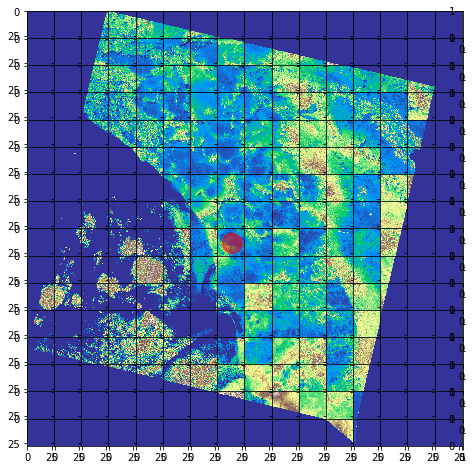

In [33]:
print_environment(environment, [START[0], START[1]])

In [34]:
# All actions A Fire can take: A - [N, S, E, W, NW, SW, NE, SE Stay]
# actions = [(-1,0),
#            (1,0), 
#            (0,1),  
#            (0,-1),
#            (-1,-1), #NW
#           (1,-1), #SW
#           (-1,1), #NE
#           (1,1), #SE
#           (0,0)]

def get_wind_dir_coordinates(wind_dir):
    w_x = 0
    w_y = 0
    if wind_dir == 0:
        w_x = -1
        w_y = 0
    elif wind_dir == 1:
        w_x = 1
        w_y = 0
    elif wind_dir == 2:
        w_x = 0
        w_y = 1
    elif wind_dir == 3:
        w_x = 0
        w_y = -1
    elif wind_dir == 4:
        w_x = -1
        w_y = -1
    elif wind_dir == 5:
        w_x = 1
        w_y = -1
    elif wind_dir == 6:
        w_x = -1
        w_y = 1
    elif wind_dir == 7:
        w_x = 1
        w_y = 1
        
        
    return w_x, w_y

# STEP[6]: Get next fire position

In [35]:
def get_new_position(old_pos, action, environment):
    """
    Get a new position using the old position
    :param tuple old_pos: (x,y) position of the fire
    :param action: action is the next fire direction of the cell
    :param list environment
    :return x+action[0], y+action[1]: (new_x,new_y)
    """
    
    rows = MAX_ROWS
    cols = MAX_COLS
    
    #w_x, w_y = get_wind_dir_coordinates(wind_dir)
    x, y = old_pos[0], old_pos[1]
    
    new_x, new_y = x + action[0], y + action[1]
    # not burned cell
    #2d to 1d index
    flat_idx = cols * new_x + new_y
    if is_valid_bounds(new_x, new_y, rows, cols)  and environment[flat_idx][5] != 3:
        #environment[flat_idx][4] = 1
        #CLASSES[flat_idx] = 1
        return new_x, new_y, environment[flat_idx][5],1, environment[flat_idx][6], environment[flat_idx][7], environment[flat_idx][8]
    # State remains the same
    return x, y, environment[x][5], 1, environment[x][6], environment[x][7], environment[x][8]

def is_valid_bounds(x, y, rows, cols):
    return x >= 0 and x < rows and y >= 0 and y < cols

In [36]:
def get_nearest_open_cell(environment, x_initial, y_initial, open = [START, GOAL]):
    
    # Record number of rows (lines) and columns in the environment
    rows = int(len(environment) / MAX_ROWS)
    cols = len(environment) % MAX_COLS
    
    # Add expanded coverage for searching for nearest open cell
    max_radius = max(rows,cols)
 
    # Generate a search radius for each scenario
    for radius in range(max_radius):
        x_off_range = range(-radius, radius + 1)

    # For each value in the search radius range of x
    for x_offset in x_off_range:

    # Start near to crash site and work outwards from there
        x = x_initial + x_offset
        y_radius = radius - abs(x_offset)
        y_range = range(y_initial - y_radius, y_initial + y_radius + 1)

        # For each value in the search radius range of y
        for y in y_range:
            # We can't go outside the grid boundary
            if x < 0 or x >= rows: continue
            if y < 0 or y >= cols: continue

            # If we find and open cell, return that (x,y) open cell for fire to spread
            return (x, y)  
     
    # No open grid squares found in the environment
    return

In [37]:
def act(old_x, old_y, old_veg_type, old_fire, old_ws, old_wd, old_temp, action, environment, deterministic=(
    False)):
    """
    This method generates the new state s' from the old
    state s and the action a 
    """
    rows = int(len(environment) / MAX_ROWS )
    cols = len(environment) % MAX_COLS
    
    # This method is deterministic if the same output is returned given
    # the same input information
    if not deterministic:
 
        if random() > PROB_SUCCESS: 
            action = (0,0)
            
    # Using the wind direction, update new fire position
    new_x, new_y, new_veg_type, new_fire, new_ws, new_wd, new_temp = get_new_position((old_x,old_y), action,( 
                                     environment))
    
    
    if [new_x, new_y] != START and (new_x, new_y) != GOAL:
    # Return the new state
        return new_x, new_y, new_veg_type, new_fire, new_ws, new_wd, new_temp
    
    
    return old_x, old_y, old_veg_type, old_fire, old_ws, old_wd, old_temp
 

# STEP[8]: Generate Policy

In [38]:
def get_policy_from_Q(cols, rows, Q, actions):
    """
    This method returns the policy pi(s) based on the action taken in each state
    that maximizes the value of Q in the table Q[s,a]. This is pi*(s)...the
    best action that the fire should take in each state is the one that 
    maximizes the value of Q.
    :param int rows: Number of rows (i.e. lines / MAX_ROWS) in the environment
    :param int cols: Number of cols (i.e. lines % MAX_COLS) in the environment
    :param list of tuples actions: actions - [N, S, E, W, NW, SW, NE, SE Stay]
    :return pi : the policy
    :rtype: dictionary: key is the state tuple, value is the 
       action tuple A - [N, S, E, W, Stay]
    """
    # Create an empty dictionary called pi
    pi = {}
 
    # For each state s in the environment
    for x in range(0, rows): 
        for y in range(0, cols): 
            for veg in states_range['veg_type_range']:
                for fire in states_range['fire_range']:
                    for ws in states_range['ws_range']:
                        for wd in states_range['wd_range']:
                            for temp in states_range['temp_range']:
                                # choose the policy with the maximum reward
                                pi[(x, y,veg,fire,ws,wd,temp)] = actions[np.argmax(Q[x][y][veg][fire][ws][wd][temp])]        
    return(pi)

# STEP[9]: Run Q Learning Model

In [39]:
def q_learning(environment, no_training_iter =( 
    NO_TRAINING_ITERATIONS), train_iter_length = TRAIN_ITER_LENGTH):
    """ 
    Return a policy pi that maps states to actions
    Each episode uses a different initial state. This forces the agent to fully
    explore the environment to create a more informed Q[s,a] table.
    :param list environment
    :param int no_training_iter
    :param int train_iter_length
    :return policy pi(s) which maps a given state to an optimal action
    :rtype dictionary
    """
    rows = MAX_ROWS
    cols = MAX_COLS
    
    
    # Initialize all Q(s,a) to arbitrary values 
    # (i.e. finish line states) that has a value of 0.
    # Q[x][y][veg][fire][ws][wd][temp][ai]
    Q = [[[[[[[[random() for _ in actions] for _ in states_range['temp_range']] for _ in states_range['wd_range']] 
             for _ in states_range['ws_range']] for _ in states_range['fire_range']] for _ in states_range['veg_type_range']] 
                for _ in range(0, cols)]
                    for _ in range(0, rows)]
    
    # Set finish line state-action pairs to 0
    for x in range(0, rows): 
        for y in range(0, cols): 
            # Terminal state has a value of 0
            if (x,y) == GOAL:
                for veg in states_range['veg_type_range']:
                    for fire in states_range['fire_range']:
                        for ws in states_range['ws_range']:
                            for wd in states_range['wd_range']:
                                for temp in states_range['temp_range']:
                                    for ai, a in enumerate(actions):
                                        Q[x][y][veg][fire][ws][wd][temp][ai] = 1
                                    
 
                              
     
    # We run many training iterations for different initial states in order
    # to explore the environment as much as possible
    for iter in range(no_training_iter):
         
        # Select a random initial state
        # from anywhere on the grid
        x = np.random.choice(range(0, rows))
        y = np.random.choice(range(0, cols)) 
        veg = np.random.choice(states_range['veg_type_range']) 
        fire = np.random.choice(states_range['fire_range'])
        ws = np.random.choice(states_range['ws_range'])
        wd = np.random.choice(states_range['wd_range'])
        temp = np.random.choice(states_range['temp_range'])
        
        
        # Do a certain number of iterations
        for t in range(train_iter_length):
            if (x, y) == GOAL: 
                break
            flat_idx = cols * x + y
            if environment[flat_idx][5] == 2 or environment[flat_idx][5] == 3 or environment[flat_idx][5] == 4 or environment[flat_idx][5] == 6:
                break
                
            # Choose the best action for the state s
            a = np.argmax(Q[x][y][veg][fire][ws][wd][temp])           
             
            # Act and then observe a new state s'
            new_x, new_y, new_veg_type, new_fire, new_ws, new_wd, new_temp = act(x, y, veg, fire,  ws, wd, temp, actions[
                a], environment) 
           
            r = 1.0
            
            # Update the Q table based on the immediate reward received from
            # taking action a in state s plus the discounted future reward
            Q[x][y][veg][fire][ws][wd][temp][a] = ((1 - LEARNING_RATE)*Q[x][y][veg][fire][ws][wd][temp][a] + LEARNING_RATE*(r + GAMMA*max(Q[new_x][new_y][new_veg_type][new_fire][new_ws][new_wd][new_temp])))
 
            # The new state s' now becomes s
            x, y, veg, fire, ws, wd, temp = new_x, new_y, new_veg_type, new_fire, new_ws, new_wd, new_temp
            
 
    return(get_policy_from_Q(cols, rows, Q, actions))

# STEP[10]: Model Evaluation

In [40]:
def model_evaluation(environment, policy, animate = False, 
                  max_steps = MAX_STEPS):
    """
    Fire Spread according to the policy.   
    :param list environment
    :param dictionary policy: A dictionary containing the best action for a 
        given state. The key is the state [v, f, ws, wd, t] and value is the action 
        [N, S, E, W, Stay]
    :param boolean animate: If true, show the fire spread after each 
        timestep
    :return i: Total steps to complete the fire spread
    :rtype int
 
    """
    # Copy the environment
    environment_display = deepcopy(environment)
 
    # Get a initial state for the fire
    x, y, fire, veg_type, ws, wd, temp  = START
  
    
    # Keep track if there is water or fire can't spread anymore
    stop_clock = 0   
 
    # Begin time trial
    for i in range(max_steps):        
        
        if animate: 
            #print_environment(environment_display, fire_position = [x, y, fire, veg_type, ws, wd, temp])
            print_environment(environment_display, fire_position = [x, y])
         
        # Get the best action given the current state
        a = policy[(x, y, veg_type, fire, ws, wd, temp)]
 
        # Take action and get new a new state s'
        x, y, veg_type, fire, ws, wd, temp = act(x, y, veg_type, fire, ws, wd, temp, a, environment)
 
        # Determine if there is water
        if veg_type == 3:
            stop_clock += 1
        else:
            stop_clock = 0
 
        if stop_clock == 5:
            return max_steps
         
    # Program has timed out
    return max_steps

# STEP[11]: Run Model Main function

In [41]:
def main():
    """
    The main method of the program
    """   
    print("Predict Fire Spread!")
    print("" + ALGORITHM_NAME +
          " Reinforcement Learning Algorithm\n")
    print()

    no_training_iter = int(input(
        "Enter the initial number of training iterations (e.g. 5): "))
    print("\nTraining the model. Please wait...")
 
    dataset_name = FILENAME
    environment = read_environment(dataset_name)
 
    trials = NO_OF_TRIALS
 
    while(no_training_iter < MAX_TRAIN_ITER):
     
        # Keep track of the total number of steps
        total_steps = 0
 
        # Retrieve the policy
        policy = q_learning(environment,
                             no_training_iter=no_training_iter) 
  
        for trial in range(trials):
            total_steps += model_evaluation(environment, policy, animate = True)
 
        print("Number of Training Iterations: " + str(no_training_iter))
       
        print("Average Number of Steps taken " + str(total_steps/trials) + " steps\n")
     
 
        # Delay 
        time.sleep(FRAME_TIME + 4)
 
 
        no_training_iter += 5

Predict Fire Spread!
Q_Learning Reinforcement Learning Algorithm


Enter the initial number of training iterations (e.g. 5): 3

Training the model. Please wait...


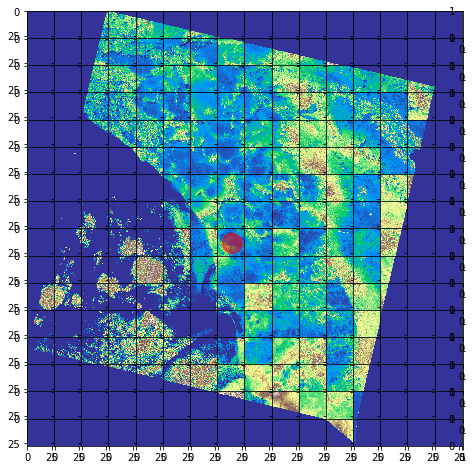

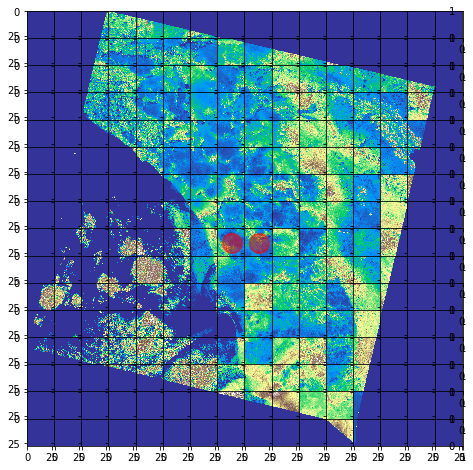

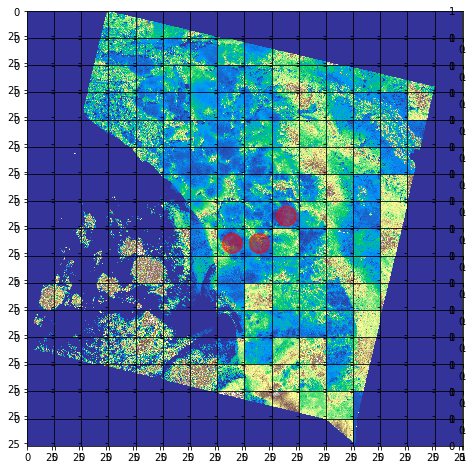

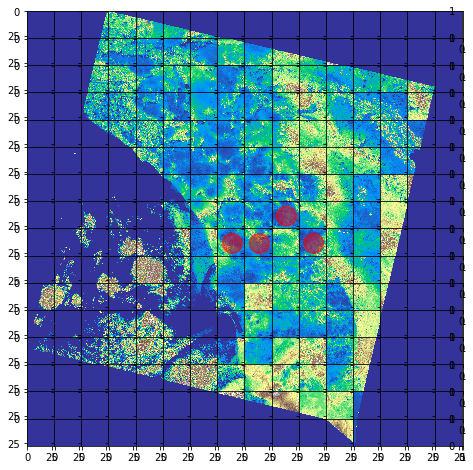

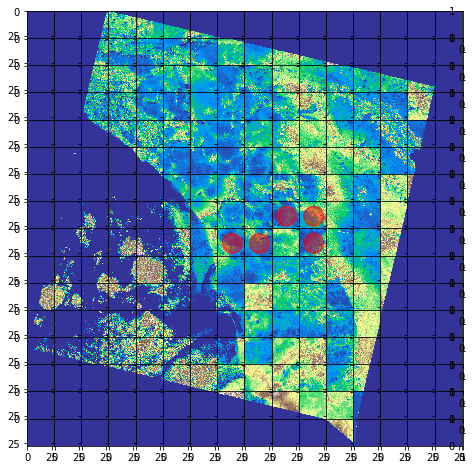

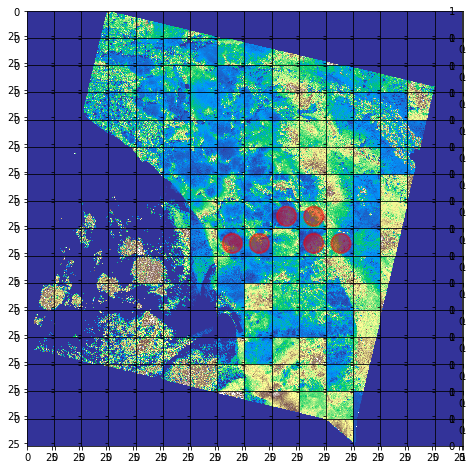

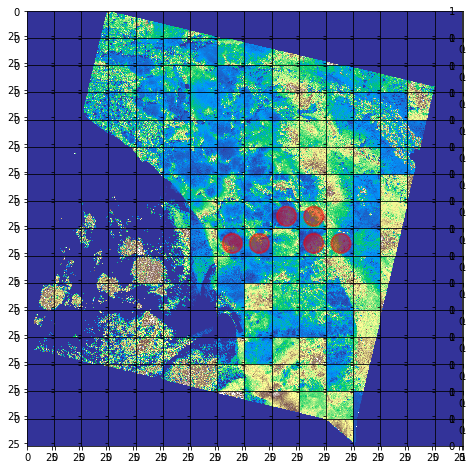

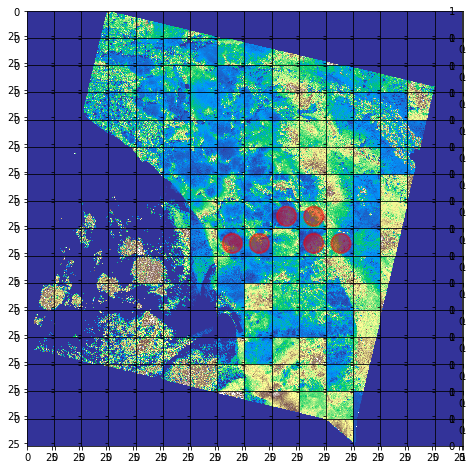

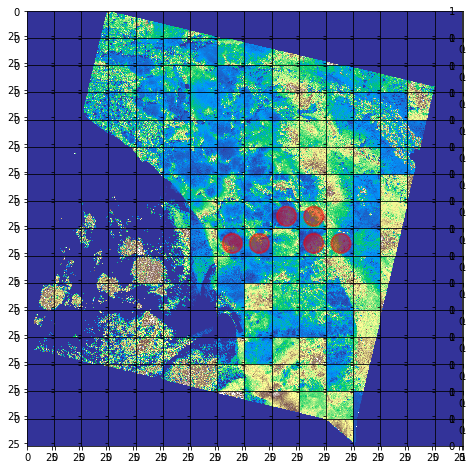

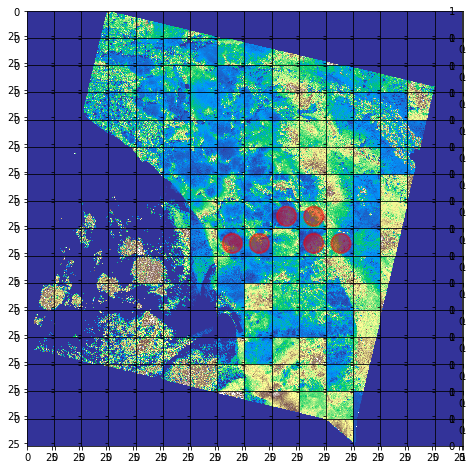

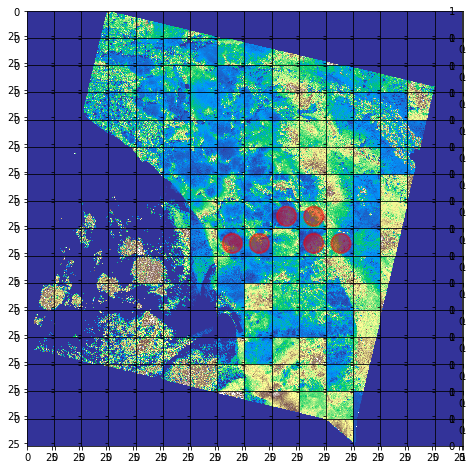

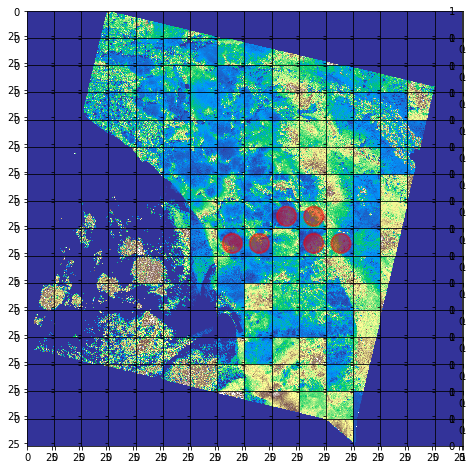

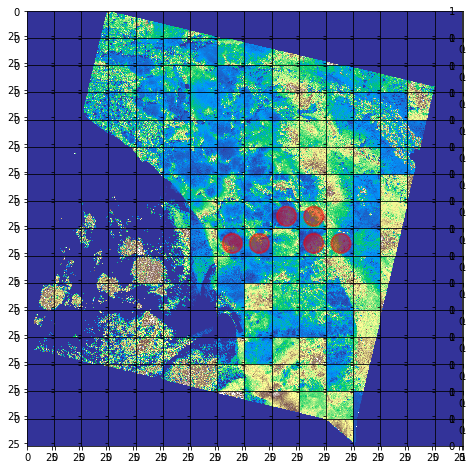

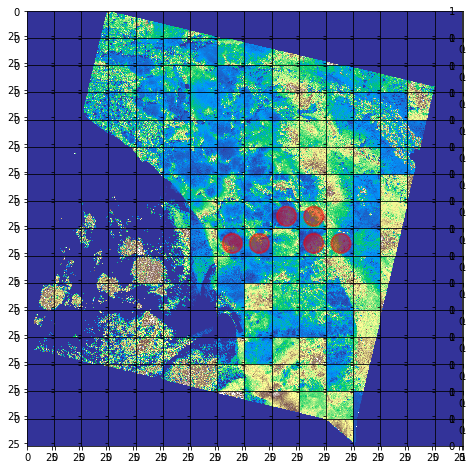

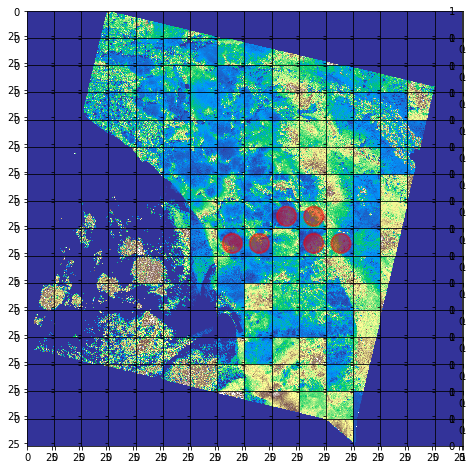

KeyboardInterrupt: 

In [42]:
main()